In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os.path

%matplotlib inline

In [ ]:
# Every row is a wheel+width+tension
data = pd.DataFrame()

for fname in glob('../data/buckling_tension_K2/CR18-700_36sp_inbound/[!~]*_info.csv'):
    # Each file is a hub width

    d = pd.read_csv(fname, index_col=[0])
    
    f_noext = os.path.splitext(fname)[0]
    
    # Read load-displacement data
    Pd = pd.read_csv(f_noext[:-4]+'data.csv')
    
    for t in Pd['Tension [N]'].unique():
        Pd_t = Pd[Pd['Tension [N]'] == t]
        
        K2_lin = 16*np.polyfit(Pd_t['displacement [mm]'], Pd_t['delta Load [N]'], 1)[0]
        K2_quad = 16*np.polyfit(Pd_t['displacement [mm]'], Pd_t['delta Load [N]'], 2)[1]
        
        data = data.append(d['Value'].append(pd.Series({'Tension [N]': t,
                                                        'K2_lin': K2_lin,
                                                        'K2_quad': K2_quad})),
                           ignore_index=True)

data['Flange spacing'] = data['Flange spacing'].astype(np.float)
data.head()

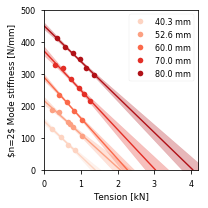

In [3]:
n_widths = data[data['Flange spacing'] > 25]['Flange spacing'].nunique()
cp = sns.color_palette('Reds', n_widths)

with plt.style.context(('seaborn-paper')):

    fig, ax = plt.subplots(figsize=(3, 3))
    
    for i, w in enumerate(sorted(set(data[data['Flange spacing'] > 25]['Flange spacing'].tolist()))):
        T = data[data['Flange spacing'] == w]['Tension [N]']
        K2 = data[data['Flange spacing'] == w]['K2_quad']

        fit = np.polyfit(T, K2, 1)
        
        TT = np.linspace(0., 5000, 100)
        
        # Calculate confidence interval
        mean_x = np.mean(T)     # mean of x
        n = len(T)              # number of samples in origional fit
        t = 2.31                # appropriate t value (where n=9, two tailed 95%)
        s_err = np.sum((K2 - (fit[0]*T + fit[1]))**2)   # sum of the squares of the residuals

        confs = t*np.sqrt((s_err/(n-2))*(1./n + (np.power((TT-mean_x),2)/
                                         ((np.sum(np.power(T,2)))-n*(np.power(mean_x,2))))))
 
        
        ax.plot(T/1000., K2, 'o', color=cp[i], label='{0:.1f} mm'.format(w))
        ax.plot([0., -fit[1]/fit[0]/1000], [fit[1], 0.], '-', color=cp[i])
        
        # Plot 95% confidence interval
        ax.fill_between(TT/1000, (fit[0]*TT + fit[1]) + confs, (fit[0]*TT + fit[1]) - confs,
                        color=cp[i], alpha=0.3)
        
    ax.axis([0., 4.2, 0., 500])
        
    ax.set_xlabel('Tension [kN]')
    ax.set_ylabel('\$n=2\$ Mode stiffness [N/mm]')

    ax.legend(loc='best')

    plt.tight_layout()
    plt.savefig('../figs/buckling_tension/_python_K2_vs_tension.pdf')

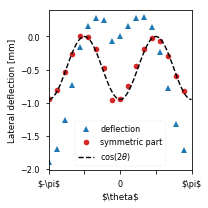

In [4]:
d = pd.read_csv('../data/buckling_tension_K2/CR18_36s_80mm_T560_deflection.txt',
                delim_whitespace=True, header=None, names=['Spoke', 'Deflection'])

d['theta'] = np.arange(0., 2*np.pi, 2*np.pi/18)

th = np.linspace(0., 2*np.pi, 100)

with plt.style.context(('seaborn-paper')):
    fig, ax = plt.subplots(figsize=(3, 3))
    
    ax.plot(d['theta'], d['Deflection'], 'C0^', label='deflection')
    ax.plot(d['theta'], d['Deflection'] - d['Deflection'][0]/2 * np.cos(d['theta']), 'C3o', label='symmetric part')
    ax.plot(th, d['Deflection'][0]/4 * (np.cos(2*th) + 1), 'k--', label=r'$\cos{ (2 \theta) }$')
    
    plt.legend(loc='lower center')
    
    ax.set_xlim([0, 2*np.pi])
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels(['\$-\pi\$','','0', '', '\$\pi\$'])
    
    ax.set_ylabel('Lateral deflection [mm]')
    ax.set_xlabel(r'\$\theta\$')
    
    plt.tight_layout()
    plt.savefig('../figs/buckling_tension/_python_4pt_bend_def.pdf')

# K2_0 vs. hub width

In [5]:
data['R'] = 0.304
data['d_hub'] = 0.058

M = 0.538
K2_rim = (2*np.pi*82.0)**2 * M / 2

print K2_rim / 1000

w_set = sorted(set(data[data['flange width'] > 25]['flange width'].tolist()))

x = np.zeros(len(w_set))
K2_0 = np.zeros(len(w_set))

for i, w in enumerate(w_set):
    row = data[data['flange width'] == w].iloc[0]

    K2_0[i] = np.polyfit(data[data['flange width'] == w]['tension'],
                         data[data['flange width'] == w]['K2_quad'], 1)[1]

    alpha = np.arctan2(row['flange width']/2000., row['R'] - row['d_hub']/2)
    ls = np.sqrt((row['flange width']/2000)**2 + (row['R'] - row['d_hub']/2)**2)
    
    x[i] = 36 * np.sin(alpha)**2 / ls
    
fig, ax = plt.subplots(figsize=(3, 3))

ax.set_xlim([0, 3.0])
ax.set_ylim([0., 500.])
sns.regplot(x=x, y=K2_0, ax=ax)


ax.plot([0., 3.5], [K2_rim/1000, K2_rim/1000], 'r--')

ax.set_xlabel(r'$n_s \sin^2 \alpha / l_s$')
ax.set_ylabel('Zero-tension stiffness [N/mm]')

plt.tight_layout()
# plt.savefig('4pt_bend_K2_spokes.pdf')

71.4068247124


KeyError: 'flange width'